# CS224 - Fall 2024 - PROGRAMMING ASSIGNMENT 3 - DNN

**Due**: December 12, 2024 @ 11:59pm PDT **(NO LATE DAYS ALLOWED DUE TO GRADE SUBMISSION DEADLINE)**

**Maximum points**: 15

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Aaryan Bhagat
  </br>
  <b>Student ID Number</b>:  862468325
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

<div style="padding: 15px; color: #8a6d3b; background-color: #fcf8e3; border: 1px solid #faebcc; border-radius: 5px;">
<b><font size=+2>Academic Integrity</font></b></br>
Each assignment should be done  individually. You may discuss general approaches with other students in the class, and ask questions to the TA, but  you must only submit work that is yours . If you receive help by any external sources (other than the TA and the instructor), you must properly credit those sources. The UCR Academic Integrity policies are available at <a href="http://conduct.ucr.edu/policies/academicintegrity.html" target="_blank">http://conduct.ucr.edu/policies/academicintegrity.html</a>.
</div>

# Overview
In this assignment you will extract the Deep Convolutional Neural Network features of a dataset(Question 1), implement multinomial logistic regression(Question 2) and ROC curve(Question 3).  

For this assignment we will use the functionality of [PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html), [Numpy](http://www.numpy.org/), and [Matplotlib](https://matplotlib.org/).

If you are asked to **implement** a particular functionality, you should **not** use an existing implementation from the libraries above (or some other library that you may find). When in doubt, **please ask**.

Before you start, make sure you have installed all those packages in your local Jupyter instance.


Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the code marked `TODO` and answer descriptive/derivation questions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import Variable

import scipy.io as sio


DO **NOT** MODIFY ANYTHING IF NOT MENTIONED.

# **Question 1: DNN [4 points]**
In this problem, you are required to extract the Deep Convolutional Neural Network (CNN)
features for a dataset.

The dataset provided is the [**MNIST**](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) dataset.

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None);

You need to extract features from these images using the [**ResNet-50**](https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/) architecture available in PyTorch.

You need to fill in the function named `extract`, which loads the images, extracts the features and appends them to the feature list along with the corresponding labels. The output of this code is the file `'mnist_train.mat` and `mnist_test.mat`, which are to be used in the next problem. This file should have

1. `features` of dimension $m\times n$, where $m=60000$ is the number of images and $n=2048$ is the feature dimension obtained using ResNet-50.
1.  `labels` is a vector of length $m$ containing labels from 0 to 9 for the 10 categories.

Some portions of the code is already filled in for convenience. Please do **not** modify anything if not mentioned.



In [3]:
def extract(dataset, filename):
    features = []
    labels = []

    transform_test = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    model = models.resnet50(pretrained=True) # TODO: get ResNet-50 from PyTorch
    extractor = torch.nn.Sequential(*list(model.children())[:-1])

    extractor.eval()

    for (_img, label) in dataset:
        # TODO: fill in to load image, preprocess, and extract features
        # the output variable F expected to be the feature of the image of dimension (2048,)
        img = transform_test(_img).unsqueeze(0)
        with torch.no_grad():
            F = extractor(img)# TODO
            F = F.view(F.size(0), -1).squeeze()
        # print(F.shape)
        # break
        # exit()
        features.append(F)
        labels.append(label)

    sio.savemat(filename, mdict={'features': features, 'labels': labels})

Run the code below to get extracted features and labels of MNIST dataset, and then save it to `.mat` file. (This might take a while.)

You do **not** need to submit the `.mat` file along with the PDF file.

In [4]:
extract(mnist_trainset, 'mnist_train.mat')
extract(mnist_testset, 'mnist_test.mat')

/Users/berserker/.pyenv/versions/3.11.6/envs/ml_course/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/berserker/.pyenv/versions/3.11.6/envs/ml_course/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Question 2: Multinomial Logistic Regression [4 points]**
In this problem, you will implement the multinomial logistic regression using the extracted features and labels in Question 1.

You should use variables `trfeature` and `trlabel` for training and `tefeature` and `telabel` for testing.

Please remember to map the labels properly for testing. You need to fill in the function named `apply_gradient`, which returns the updated parameter $\theta$ after a single pass of gradient descent using the given data points and labels. You also need to fill up certain the portions as mentioned in function `mlr`.


- Using built-in functions like `sklearn.linear_model.LogisticRegression()` will **not** give you any points.
- Please do **not** modify anything if not mentioned.

In [5]:
BATCH_SIZE = 64# TODO: fill in and modify to see change in performance
LR = 0.001# TODO: learning rate; fill in and modify to see change in performance

def get_one_hot(labels):
    cats = np.unique(labels)
    onehot = np.zeros((labels.size, cats.size))
    onehot[np.arange(labels.size), labels] = 1.
    return onehot

def plot(acc):
    plt.plot(np.arange(len(acc)),  acc, 'b-')
    plt.xlabel('Epoch Number')
    plt.ylabel('Test Accuracy')
    plt.show()


# X is a matrix of size n_samples x n_feature
# L is a vector of size n_samples x n_category
# theta is a matrix of size n_feature x n_category
def apply_gradients(X, L, theta):
    l = X.dot(theta)
    m = X.shape[0]
    e_logits = np.exp(l - np.max(l, axis=1, keepdims=True))
    p = e_logits / np.sum(e_logits, axis=1, keepdims=True)
    gr = X.T.dot(p - L) / m
    new_theta = theta - LR * gr # TODO
    return new_theta

def mlr(trfeature, tr_onehot, tefeature, te_onehot):
    m_tr = tr_onehot.shape[0] # number of training samples

    theta = np.random.randn(trfeature.shape[1], tr_onehot.shape[1]) * 0.001# TODO: initialize
    diff = 1
    epoch = 0

    predonehot = []
    test_accuracy_list = []
    while diff > 1e-10 and epoch < 1000:
        theta_old = theta
        # Train
        for i in range(0, m_tr, BATCH_SIZE):
            endpos = min(m_tr, i+BATCH_SIZE-1)
            theta = apply_gradients(trfeature[i:endpos,:], tr_onehot[i:endpos,:], theta)

        diff = np.linalg.norm(theta_old-theta)

        # TODO: predict on the test dataset
        # fill in to assign the corresponding probabilities to variable predonehot rather than the real one-hot encoding
        # the shape of predonehot is (n_sample,n_ categories); we will need this variable in Question 3
        logit = tefeature.dot(theta)
        e_logit = np.exp(logit - np.max(logit, axis=1, keepdims=True))
        # Using Softmax now to get predicted probabilities of the classifier
        pred = e_logit / np.sum(e_logit, axis=1, keepdims=True)
        pred_labels = np.argmax(pred, axis=1) # Getting predicted labels
        predonehot = get_one_hot(pred_labels) # YOUR CODE HERE

        # TODO: fill in to assign test accuracy to variable test_accuracy
        test_accuracy = np.mean(pred_labels == np.argmax(te_onehot, axis=1))# YOUR CODE HERE
        test_accuracy_list.append(test_accuracy)

        epoch += 1
        # Update learning rate if you want

    plot(test_accuracy_list)

    print('Test Accuracy: %.5f'%(test_accuracy_list[-1]))

    return predonehot

Run the code below, check the accuracy plot, and report the test accuracy you obtain.

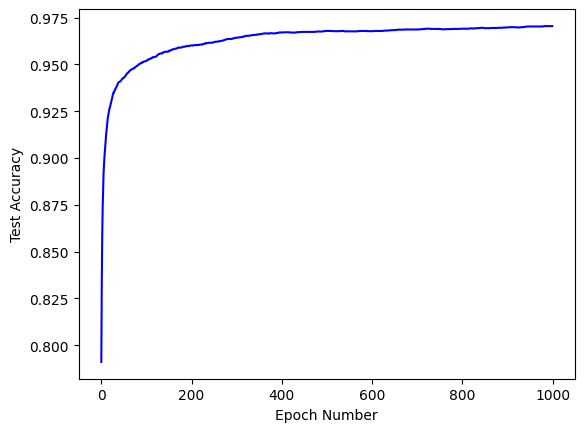

Test Accuracy: 0.97050


In [6]:
# get the extracted features from Question 1
trmat = sio.loadmat('mnist_train.mat')
temat = sio.loadmat('mnist_test.mat')

trfeature, trlabel = trmat['features'], trmat['labels']
tefeature, telabel = temat['features'], temat['labels']

teonehot = get_one_hot(telabel)
# fit multinomial logistic regression
# we will need the variable predonehot for next question
predonehot = mlr(trfeature, get_one_hot(trlabel), tefeature, teonehot)

# **Question 3: VAE [7 points]**
In this question, you'll implement and train a Variational Autoencoder (VAE) to generate and reconstruct images from the MNIST dataset.

In [7]:
# Load MNIST dataset
transform = transforms.Compose([
        transforms.ToTensor(),
    ])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)



In [8]:
(next(iter(trainloader))[0].shape)

torch.Size([64, 1, 28, 28])

In [19]:
batch_size = (next(iter(trainloader))[0].shape)[0]
batch_size

64

Verify that the dataset is normalized. Check the pixel values of the images to ensure they are in the range $[0, 1]$. You can use the following code to check.

In [9]:
print('min: ', next(iter(trainloader))[0].min().item())
print('max: ', next(iter(trainloader))[0].max().item())

min:  0.0
max:  1.0


**(a) Define an Encoder Network [1 point]**

The Encoder compresses the input image into a lower-dimensional latent representation. This latent representation is characterized by two parameters: the mean (`mu`) and the log-variance (`logvar`) of a Gaussian distribution. These parameters allow the model to learn probabilistic latent features, which are essential for generating diverse outputs.

This block below defines the Encoder, which transforms the 28x28 input images (flattened to 784 features) into a latent space with a reduced dimension `z_dim`. This compression step is crucial for learning a compact representation of the data.

1. The first layer reduces the dimensionality from 784 to 400 using a fully connected layer with ReLU activation (you could use `torch.relu(*)`).
2. Two separate layers (`fc2_mu` and `fc2_logvar`) output the mean and log-variance of the latent space. These outputs are key to representing the data distribution.
3. Set the latent dimension (`z_dim`) to 20 when initializing the Encoder. You can experiment with different values later to observe their effects on reconstruction quality.

In [15]:
# Encoder Network
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        # TODO: Mean of latent space
        self.fc2_mu =  nn.Linear(400, z_dim)# YOUR CODE HERE
        # TODO: Log variance of latent space
        self.fc2_logvar =  nn.Linear(400, z_dim)# YOUR CODE HERE

    def forward(self, x):
        # TODO: Flatten and apply relu
        x = x.view(-1, 784) # Flatten the image (batch_size, 784)
        h1 =  torch.relu(self.fc1(x)) # YOUR CODE HERE
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar


**(b) Define a Decoder Network [1 point]**

The Decoder reconstructs the original image from the latent representation. It maps the reduced latent space back to the original image dimensions, ensuring the reconstructed output matches the scale and shape of the input.

In [11]:
# Decoder Network
class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.fc3 = nn.Linear(z_dim, 400)
        self.fc4 = nn.Linear(400, 784) # YOUR CODE HERE

    def forward(self, z):
        # TODO: Apply relu after fc3
        h3 = torch.relu(self.fc3(z)) # YOUR CODE HERE
        # TODO: Apply sigmoid after fc4 to keep values in [0, 1]
        # Convert to original size
        z = torch.sigmoid(self.fc4(h3)) # YOUR CODE HERE
        return z

**(c) Define the VAE model [2 points]**

Now we will implement a Variational Autoencoder (VAE) consisting of an Encoder, a Decoder, and a reparameterization trick to model the latent distribution.

The reparameterization trick ensures that the latent space can be sampled in a way that allows gradients to flow through the network during training. Each of these components works together to model the latent distribution and enable the reconstruction of input data.

The implementation below will serve as the foundation for the training process, where we will optimize the model to learn meaningful representations of the data.

In [12]:
# VAE Model combining Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def reparameterize(self, mu, logvar):
        std =  torch.exp(0.5 * logvar) # YOUR CODE HERE
        eps =  torch.randn_like(std) # YOUR CODE HERE
        z =  mu + std * eps # YOUR CODE HERE
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


**(d) Define a loss function [1 point]**

The loss function in VAEs combines two distinct components: *reconstruction loss* and *KL divergence*. The reconstruction loss ensures the model is learning to generate images that are similar to the input images, while the KL divergence ensures that the distribution of the latent variables is close to a standard normal distribution.

In [13]:
# Loss Function: Reconstruction loss + KL divergence
def loss_function(recon_x, x, mu, logvar):
    """
    Compute the VAE loss, combining reconstruction loss and KL divergence.

    recon_x: reconstructed images from the decoder
    x: original input images
    mu: mean of the latent distribution
    logvar: log-variance of the latent distribution
    """

    # TODO: Flatten the images for binary cross-entropy (784-dimensional vectors)
    # You may use `nn.functional.binary_cross_entropy(*)`
    bce =  torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum') # YOUR CODE HERE

    # TODO: KL Divergence
    kl =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # YOUR CODE HERE

    return bce + kl

**(e) Training process [1 point]**

Now we will train the VAE and monitor the loss.

In [20]:
# Training loop with debugging output
def train_vae(model, trainloader, optimizer, loss_function, epochs=20, device="cpu"):
    model.train()  # Set model to training mode

    avg_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(trainloader):
            data = data.to(device)  # Send data to device (CPU or GPU)
            optimizer.zero_grad()  # Reset gradients

            # TODO: Forward pass
            # YOUR CODE HERE
            recon_x, mu, logvar = model(data) # Get output from forward pass
            # Compute loss
            loss =  loss_function(recon_x, data, mu, logvar)# YOUR CODE HERE

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Compute and store average loss for this epoch
        avg_loss = total_loss / (len(trainloader) * batch_size) # YOUR CODE HERE
        avg_losses.append(avg_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    return avg_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer
z_dim = 20

model = VAE(z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

avg_losses = train_vae(model, trainloader, optimizer, loss_function, epochs=num_epochs, device=device)

Epoch 1/15, Loss: 146.3471
Epoch 2/15, Loss: 115.5958
Epoch 3/15, Loss: 111.3227
Epoch 4/15, Loss: 109.3319
Epoch 5/15, Loss: 108.0913
Epoch 6/15, Loss: 107.3092
Epoch 7/15, Loss: 106.6608
Epoch 8/15, Loss: 106.1777
Epoch 9/15, Loss: 105.8436
Epoch 10/15, Loss: 105.5421
Epoch 11/15, Loss: 105.2280
Epoch 12/15, Loss: 104.9644
Epoch 13/15, Loss: 104.7823
Epoch 14/15, Loss: 104.5572
Epoch 15/15, Loss: 104.3892


Use this function to plot the loss trend after training.

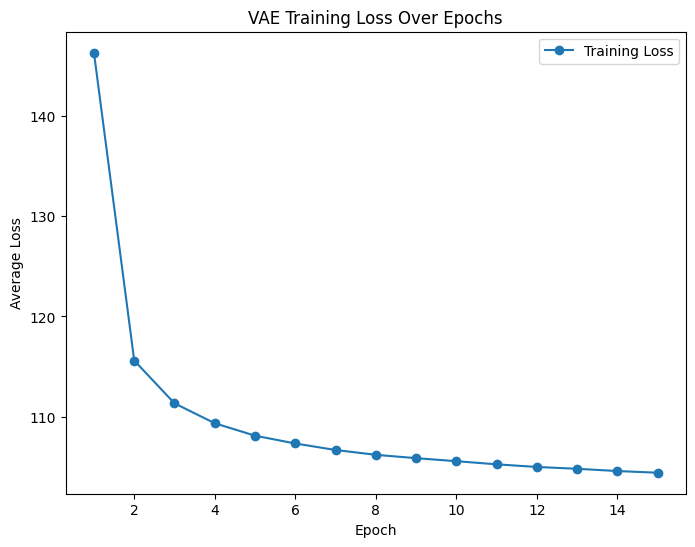

In [21]:
def plot_loss(avg_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(avg_losses) + 1), avg_losses, marker='o', label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("VAE Training Loss Over Epochs")
    plt.legend()
    plt.show()

# Plot the training loss
plot_loss(avg_losses)

After training, we use the model to generate reconstructions of input images. This helps assess how well the VAE captures important image features.

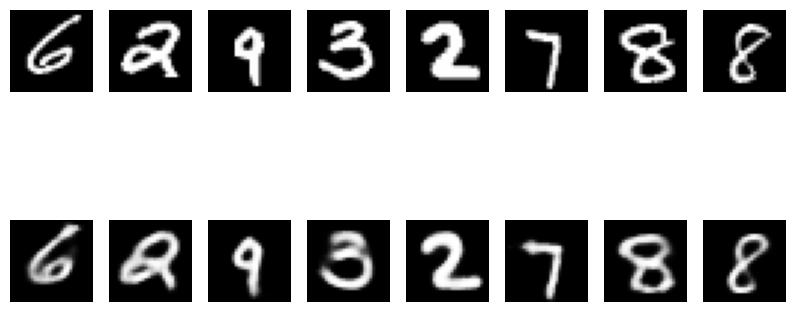

In [22]:
# Visualizing reconstructed images
def visualize_latent_space(model, device="cpu"):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Sample from a standard normal distribution
        images, _ = next(iter(trainloader))
        images = images.to(device)
        recon_images, _, _ = model(images)

        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, 8, figsize=(10, 5))
        for i in range(8):
            axes[0, i].imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
        plt.show()

visualize_latent_space(model)


**(f) Generate new images [1 point]**

Now we will use the Decoder to generate new images by sampling from the latent space. This step will demonstrate the generative capabilities of the VAE and give you a chance to visualize how well the model has learned the underlying data distribution.

The Decoder can generate new samples by decoding latent vectors. Instead of encoding from real input images, we will directly sample random vectors from a Gaussian distribution, which represents the prior distribution in the latent space.

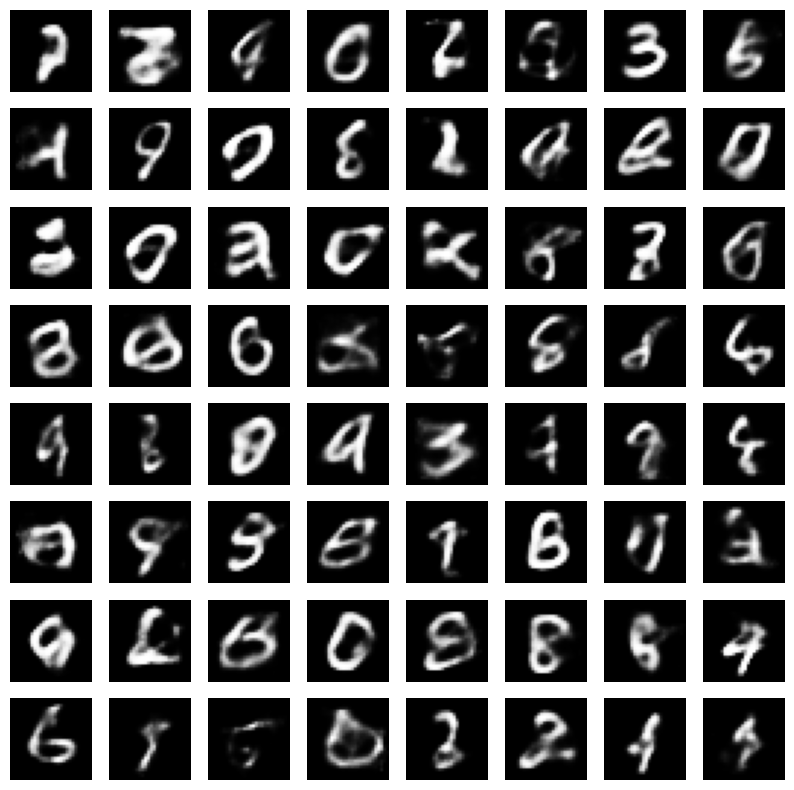

In [23]:
def generate_samples(model, num_samples=64):
    model.eval()
    with torch.no_grad():
        # TODO: Sample from the latent space
        z = torch.randn(num_samples, z_dim).to(device) # YOUR CODE HERE
        generated_images = model.decoder(z) # YOUR CODE HERE

    # Plot the generated images
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

# Generate new samples after training
generate_samples(model)
